# **N2O Feature Reduction And Gap-filling 2019**

- Half-hourly fluxes and meteo data from CH-AES
- Measurements 2019: 2019051011.X52 to 2019072307.X00
- Measurements 2020: 2020051215.X15 to 2020110307.X00

# Settings

In [1]:
DATAFILE = "/work/ms-ch-aes/data/ch-aes_2019_2020_data_for_analysis_20210927/CH-AES_2019_2020_data_for_analysis_20210927.csv"
OUTFILE = "gapfilled_CH4_CH-AES_2019.csv"
SELECT_YEAR = 2019

# target = 'N2O_flag0_ustar'
target = 'CH4_flag0_ustar'
dropcols = ['CH4_flag01', 'CH4_flag0', 'N2O_flag0_ustar', 'N2O_flag01', 'N2O_flag0', 'PA', 'TA', 'RH', 'Reco', 'GPP', 'NEE', 'VPD', 'Rg', 'WFPS_0.15', 'WFPS_0.30', 'TS_0.15', 'TS_0.30']  # Not used in analysis
keep_mgmt = 'none'  # Options: 'all' keeps all management, 'bulk' keeps combined .MGMT column, 'none' removes all management, 'combos' keeps combined e.g. Nmin+Norg and also harvest
use_timesince_vars = False

# Random forest
timestamp_as_features = False
include_rolling_variants = False
include_lagged_variants = False

# Setup

## Imports

In [2]:
import os
import datetime as dt

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)

import warnings
warnings.filterwarnings('ignore')

from pkgs.randomforest_ts import RandomForestTS  # From DIIVE

In [3]:
print(f"Working directory: {os.getcwd()}")

Working directory: /work/ms-ch-aes/notebooks


## Load data from file
Load the original data file.

In [4]:
date_parser = lambda c: pd.to_datetime(c, format='%Y-%m-%d %H:%M:%S', errors='coerce')
source_df = pd.read_csv(DATAFILE, index_col=0, parse_dates=True, na_values=[-9999, 'NA'], date_parser=date_parser)
display(source_df)
display(source_df.columns)

,TA,RH,PA,Rg,TS_0.05,TS_0.15,...,harvest,Nmin,Norg,Nfert,soil,sow
TIMESTAMP,,,,,,,,,,,,,
2019-05-08 15:45:00,10.233333,94.266667,94.953333,45.000000,11.933333,11.800000,...,0,0,0,0,0,0
2019-05-08 16:15:00,10.100000,95.333333,94.940000,45.000000,11.900000,11.800000,...,0,0,0,0,0,0
2019-05-08 16:45:00,10.133333,96.033333,94.956667,39.666667,11.866667,11.700000,...,0,0,0,0,0,0
2019-05-08 17:15:00,10.133333,96.200000,95.003333,36.666667,11.766667,11.700000,...,0,0,0,0,0,0
2019-05-08 17:45:00,10.166667,96.000003,95.063333,21.333333,11.700000,11.633333,...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-03 10:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0
2020-11-03 11:15:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0
2020-11-03 11:45:00,NaN,NaN,NaN,NaN,NaN,NaN,...,0,0,0,0,0,0


Index(['TA', 'RH', 'PA', 'Rg', 'TS_0.05', 'TS_0.15', 'TS_0.30', 'WFPS_0.05', 'WFPS_0.15', 'WFPS_0.30', 'PREC', 'VPD', 'NEE', 'GPP', 'Reco', 'CH4_flag01', 'CH4_flag0', 'CH4_flag0_ustar', 'N2O_flag01', 'N2O_flag0', 'N2O_flag0_ustar', 'herb', 'harvest', 'Nmin', 'Norg', 'Nfert', 'soil', 'sow'], dtype='object')

In [5]:
# Check timestamp index for duplicates and timestamp NaTs

locs_duplicates = source_df.index.duplicated(keep='first')
print(f"Removed duplicates in index: {locs_duplicates.sum()}")
source_df = source_df[~locs_duplicates]

locs_nats = source_df.index.isnull()
print(f"Removed NaTs (missing dates) in index: {locs_nats.sum()}")
source_df = source_df[~locs_nats]

Removed duplicates in index: 1
Removed NaTs (missing dates) in index: 1


In [6]:
# Sort timestamp index
source_df = source_df.sort_index(ascending=True)

In [7]:
source_df.describe()

,TA,RH,PA,Rg,TS_0.05,TS_0.15,...,harvest,Nmin,Norg,Nfert,soil,sow
count,24461.000000,24475.000000,24465.000000,24513.000000,23939.000000,23939.000000,...,26153.000000,26153.000000,26153.000000,26153.000000,26153.000000,26153.000000
mean,12.936030,76.026378,96.175843,160.765543,15.239136,15.135057,...,0.005544,0.000918,0.001835,0.002753,0.003671,0.001835
std,7.459213,17.023136,0.683389,239.514489,6.817599,6.160020,...,0.074255,0.030280,0.042803,0.052398,0.060476,0.042803
min,-5.333333,24.966667,92.886667,0.000000,1.900000,3.002778,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.466667,63.266667,95.846667,0.000000,10.216389,10.465834,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.665000,81.100000,96.248277,14.333333,15.233333,15.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,18.017778,90.382222,96.580504,252.961103,20.100556,20.233611,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,36.200000,100.400000,98.096667,959.649957,38.166667,31.100000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
source_df.groupby(source_df.index.year).count()

,TA,RH,PA,Rg,TS_0.05,TS_0.15,...,harvest,Nmin,Norg,Nfert,soil,sow
TIMESTAMP,,,,,,,,,,,,,
2019,11305,11305,11305,11319,11246,11246,...,11393,11393,11393,11393,11393,11393
2020,13156,13170,13160,13194,12693,12693,...,14760,14760,14760,14760,14760,14760


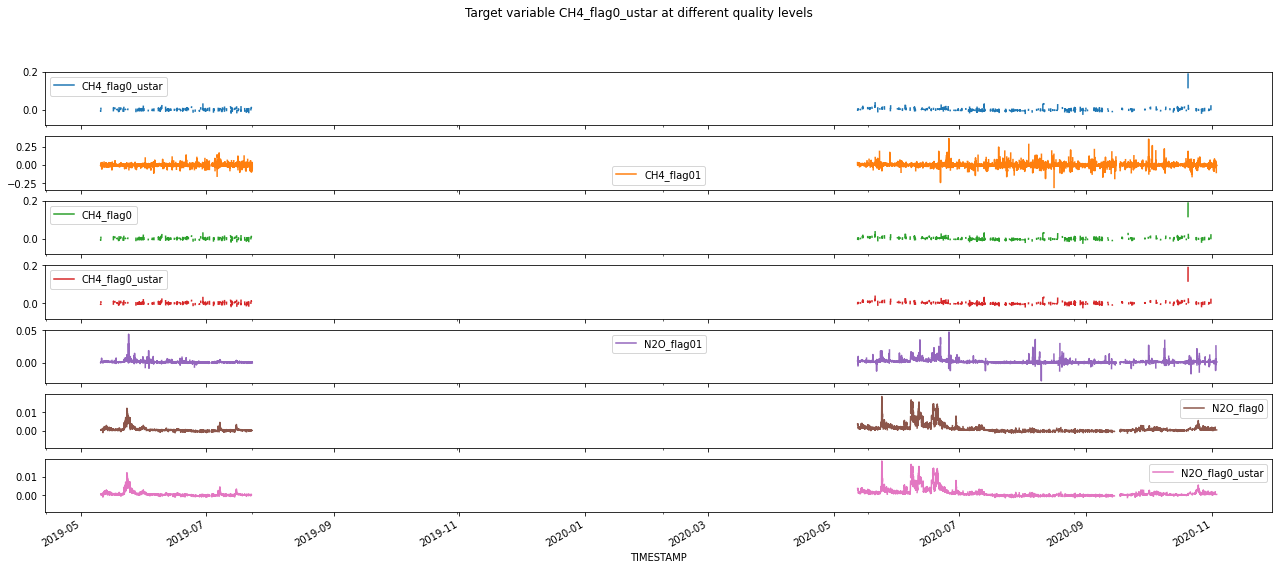

In [9]:
check_plot_cols = [target, 'CH4_flag01', 'CH4_flag0', 'CH4_flag0_ustar', 'N2O_flag01', 'N2O_flag0', 'N2O_flag0_ustar',]
plot_df = source_df[check_plot_cols].iloc[0:-1].copy()
plot_df.plot(subplots=True, figsize=(22, 9), title=f"Target variable {target} at different quality levels");

## Prepare work dataset
Dataset with reduced number of variables.  

In [10]:
df = source_df.copy()

In [11]:
# Define and rename target column
df.rename(columns={target: 'target'}, inplace=True)

In [12]:
# Remove unneeded columns
df.drop(dropcols, axis=1, inplace=True)

In [13]:
# Convert flux umol m-2 s-1 to nmol m-2 s-1
df['target'] = df['target'].multiply(1000)  

In [14]:
# Datetime of first and last available measurement of target
_first_target_value_dt = df['target'].dropna().index[0]
_last_target_value_dt = df['target'].dropna().index[-1]
print(f"First measured value of target: {_first_target_value_dt}")
print(f"Last measured value of target: {_last_target_value_dt}")
print(f"Maximum value in target: {df['target'].max()}")
print(f"Minimum value in target: {df['target'].min()}")

First measured value of target: 2019-05-10 12:15:00
Last measured value of target: 2020-11-03 07:45:00
Maximum value in target: 188.62699999999998
Minimum value in target: -68.8017


### Outliers

In [15]:
# Let's look at the 5 lowest values in target, to spot problematic outliers
display(df['target'].sort_values(ascending=True).head(20))
display(df['target'].dropna().sort_values(ascending=True).tail(20))

TIMESTAMP
2020-08-11 03:45:00   -68.8017
2020-06-10 16:15:00   -28.5678
2019-05-19 16:45:00   -24.7552
2020-07-06 00:45:00   -22.9458
2020-08-30 06:45:00   -22.5517
2019-07-11 10:45:00   -21.4266
2020-09-21 02:45:00   -20.4912
2019-07-07 03:15:00   -20.3844
2020-09-12 10:15:00   -19.9045
2020-08-31 10:15:00   -19.6579
2020-06-28 04:15:00   -18.4838
2020-08-02 06:15:00   -18.2552
2020-10-27 00:15:00   -16.9807
2020-06-14 07:15:00   -16.8277
2020-10-28 22:15:00   -16.7555
2019-07-12 23:15:00   -16.5900
2019-06-14 09:15:00   -14.5672
2020-07-06 04:15:00   -14.5005
2019-07-15 18:15:00   -14.4283
2019-07-21 13:15:00   -13.9092
Name: target, dtype: float64

TIMESTAMP
2020-05-20 06:15:00     26.3687
2020-10-22 11:15:00     26.5302
2020-08-18 00:45:00     26.6393
2020-10-20 04:15:00     27.5586
2020-09-21 06:45:00     27.6846
2020-09-28 05:15:00     27.9018
2020-09-14 07:15:00     28.0711
2020-08-10 01:15:00     28.1114
2020-08-13 01:15:00     28.4010
2020-08-10 19:45:00     29.3421
2020-10-31 18:15:00     29.4248
2020-08-11 06:45:00     30.2249
2019-06-29 06:15:00     30.3182
2020-06-25 21:15:00     30.9394
2020-07-13 06:45:00     31.3912
2020-08-11 07:15:00     32.0708
2020-05-21 05:45:00     36.9867
2020-07-02 23:15:00     42.2626
2020-10-20 10:15:00    117.3140
2020-10-20 10:45:00    188.6270
Name: target, dtype: float64

In [16]:
# Remove still existing problematic outliers
if 'CH4' in target:
    lowerlim = -25
    upperlim = 50
elif 'N2O' in target:    
    lowerlim = -2
    upperlim = None

df.loc[df['target'] < lowerlim, ['target']] = np.nan

if upperlim:
    df.loc[df['target'] > upperlim, ['target']] = np.nan

# Check again
display(df['target'].sort_values(ascending=True).head(20))
display(df['target'].dropna().sort_values(ascending=True).tail(20))

TIMESTAMP
2019-05-19 16:45:00   -24.7552
2020-07-06 00:45:00   -22.9458
2020-08-30 06:45:00   -22.5517
2019-07-11 10:45:00   -21.4266
2020-09-21 02:45:00   -20.4912
2019-07-07 03:15:00   -20.3844
2020-09-12 10:15:00   -19.9045
2020-08-31 10:15:00   -19.6579
2020-06-28 04:15:00   -18.4838
2020-08-02 06:15:00   -18.2552
2020-10-27 00:15:00   -16.9807
2020-06-14 07:15:00   -16.8277
2020-10-28 22:15:00   -16.7555
2019-07-12 23:15:00   -16.5900
2019-06-14 09:15:00   -14.5672
2020-07-06 04:15:00   -14.5005
2019-07-15 18:15:00   -14.4283
2019-07-21 13:15:00   -13.9092
2019-05-27 19:45:00   -13.5151
2020-07-13 23:15:00   -13.3604
Name: target, dtype: float64

TIMESTAMP
2020-08-27 07:45:00    24.9026
2020-09-11 07:45:00    26.3564
2020-05-20 06:15:00    26.3687
2020-10-22 11:15:00    26.5302
2020-08-18 00:45:00    26.6393
2020-10-20 04:15:00    27.5586
2020-09-21 06:45:00    27.6846
2020-09-28 05:15:00    27.9018
2020-09-14 07:15:00    28.0711
2020-08-10 01:15:00    28.1114
2020-08-13 01:15:00    28.4010
2020-08-10 19:45:00    29.3421
2020-10-31 18:15:00    29.4248
2020-08-11 06:45:00    30.2249
2019-06-29 06:15:00    30.3182
2020-06-25 21:15:00    30.9394
2020-07-13 06:45:00    31.3912
2020-08-11 07:15:00    32.0708
2020-05-21 05:45:00    36.9867
2020-07-02 23:15:00    42.2626
Name: target, dtype: float64

<AxesSubplot:>

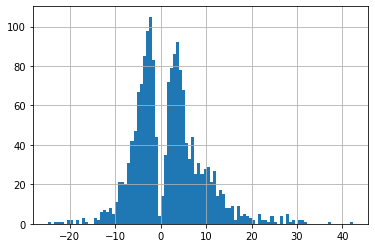

In [17]:
df['target'].hist(bins=100)
# df['target'].plot()

### Add Management Info
Since management was taking place before the first flux measurements, the date range  
of the dataset is expanded and management dates are filled in. This way certain parameters  
can be calcualted, e.g. time since last fertilization (before flux measurements).

- Management info is inserted for daytime between 8:15 and 19:45.

#### Expand date range
to also include management before the first flux measurement

In [18]:
# Create date range for start of dataset
_start = dt.datetime(2019, 4, 23, 8, 15)  # Date of first known management at the site
_end = df.index[0]
_index = pd.date_range(_start, _end, freq='30T')
_index = _index[0:-1]  # Remove last entry, already in df.index

# Use created date range to build an empty dataframe with the same columns as the available data
_expansion_df = pd.DataFrame(index=_index, columns=df.columns)
_expansion_df

,TS_0.05,WFPS_0.05,PREC,target,herb,harvest,Nmin,Norg,Nfert,soil,sow
2019-04-23 08:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 08:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 09:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 10:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2019-05-08 13:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08 13:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08 14:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-08 14:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# Add the new df to the main data
df = pd.concat([df, _expansion_df], axis=0).sort_index()

In [20]:
# Check
display(df.head(3))
display(df.tail(3))

,TS_0.05,WFPS_0.05,PREC,target,herb,harvest,Nmin,Norg,Nfert,soil,sow
2019-04-23 08:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 08:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-23 09:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,TS_0.05,WFPS_0.05,PREC,target,herb,harvest,Nmin,Norg,Nfert,soil,sow
2020-11-03 11:45:00,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
2020-11-03 12:15:00,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0
2020-11-03 12:45:00,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0


#### Soil Management
- Ploughing
- Soil preparation

In [21]:
# Remove current soil column
df = df.drop(['soil'], axis=1)

# Ploughing
df['.ploughing'] = 0  # New column
df.loc['2020-05-08 08:15:00':'2020-05-08 19:45:00', '.ploughing'] = 1  # Ploughing on 8 May 2020

# Soil preparation
df['.soilprep'] = 0  # New column
df.loc['2019-08-03 08:15:00':'2019-08-03 19:45:00', '.soilprep'] = 1  # Soil preparation on 3 Aug 2019
df.loc['2020-05-09 08:15:00':'2020-05-09 19:45:00', '.soilprep'] = 1  # Soil preparation on 9 May 2020
df.loc['2020-10-21 08:15:00':'2020-10-21 19:45:00', '.soilprep'] = 1  # Soil preparation on 21 Oct 2020

# Combined ploughing and soil preparation (they don't overlap)
df['.ploughing+soilprep'] = df['.ploughing'] + df['.soilprep']

#### Fertilization
- Organic fertilizer
- Mineral fertilizer

In [22]:
# Remove current fertilizer columns
df = df.drop(['Nfert'], axis=1)
df = df.drop(['Norg'], axis=1)
df = df.drop(['Nmin'], axis=1)

# Organic fertilizer
df['.Norg'] = 0  # New column
df.loc['2020-05-08 08:15:00':'2020-05-08 19:45:00', '.Norg'] = 1  # Solid manure on 8 May 2020
df.loc['2020-10-20 08:15:00':'2020-10-20 19:45:00', '.Norg'] = 1  # Liquid manure on 20 Oct 2020

# Mineral fertilizer
df['.Nmin'] = 0  # New column
df.loc['2020-05-22 08:15:00':'2020-05-22 19:45:00', '.Nmin'] = 1  # Urea on 22 May 2020

# Combined organic and mineral fertilizer (they don't overlap)
df['.Norg+Nmin'] = df['.Norg'] + df['.Nmin']  # Overrides the column that is already in df

#### Harvest

In [23]:
# Remove current harvest column
df = df.drop(['harvest'], axis=1)

# Harvest
df['.harvest'] = 0  # Sets the column that is already in df to zero
df.loc['2019-07-03 08:15:00':'2019-07-03 19:45:00', '.harvest'] = 1  # Harvest on 3 Jul 2019
df.loc['2019-09-15 08:15:00':'2019-09-15 19:45:00', '.harvest'] = 1  # Harvest on 15 Sep 2019
df.loc['2019-10-30 08:15:00':'2019-10-30 19:45:00', '.harvest'] = 1  # Harvest on 30 Oct 2019
df.loc['2020-05-06 08:15:00':'2020-05-06 19:45:00', '.harvest'] = 1  # Harvest on 6 May 2020
df.loc['2020-09-15 08:15:00':'2020-09-16 19:45:00', '.harvest'] = 1  # Harvest on 15 and 16 Sep 2020, harvest took place over two days

#### Sowing

In [24]:
# Remove current sowing column
df = df.drop(['sow'], axis=1)

df['.sowing'] = 0  # New column
df.loc['2019-04-23 08:15:00':'2019-04-23 19:45:00', '.sowing'] = 1  # Sowing on 23 Apr 2019
df.loc['2019-08-04 08:15:00':'2019-08-04 19:45:00', '.sowing'] = 1  # Sowing on 4 Aug 2019
df.loc['2020-05-09 08:15:00':'2020-05-09 19:45:00', '.sowing'] = 1  # Sowing on 9 May 2020

#### Herbicide / Insecticide

In [25]:
# Remove current herbicide / Insecticide column
df = df.drop(['herb'], axis=1)

# df['herb'] = 0  # Sets the column that is already in df to zero
# df.loc['2020-05-22 08:15:00':'2020-05-22 19:45:00', 'herb'] = 1  # Herbicide/insecticide on 22 May 2020

#### Combined Management

In [26]:
df['.MGMT'] = df['.ploughing'] + df['.soilprep'] + df['.Norg'] + df['.Nmin'] + df['.harvest'] + df['.sowing']  # Without 'herb'

#### Plot

In [27]:
# df[['.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing']].plot(figsize=(22,9), subplots=True, title="Management Activities");

#### Keep Management?

In [28]:
# List of management columns:
# ['.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.ploughing+soilprep', '.Norg+Nmin']

if keep_mgmt == 'all':
    print("Keeping all management in dataset.")
    pass

elif keep_mgmt == 'bulk':  # Keep .MGMT only
    print("Keeping .MGMT column only.")
    df.drop(['.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.ploughing+soilprep', '.Norg+Nmin'], axis=1, inplace=True)

elif keep_mgmt == 'none':
    print("Removing all management from dataset.")
    df.drop(['.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.ploughing+soilprep', '.Norg+Nmin'], axis=1, inplace=True)

elif keep_mgmt == 'combos':
    print("Keeping combos.")
    df.drop(['.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.sowing'], axis=1, inplace=True)    

Removing all management from dataset.


In [29]:
df.columns

Index(['TS_0.05', 'WFPS_0.05', 'PREC', 'target'], dtype='object')

### Calculate Additional Variables

#### Add Day/Night Groups
To make sure each day and night have the same amount of potential values:
- Day is between 08:15 and 19:45
- Night is between 20:15 and 07:45 the following day  

Accordingly, each day has 24 half-hourly values, and each night has 24 half-hourly values.

- kudos: https://stackoverflow.com/questions/26911851/how-to-use-pandas-to-find-consecutive-same-data-in-time-series
- https://bambielli.com/til/2018-02-11-one-hot-encoding/
- https://www.educative.io/blog/one-hot-encoding#sklearn

In [30]:
# New df to assemble day/night info, will be merged with main data later
_daynight_grps_df = pd.DataFrame(index=df.index)

# Determine day and night (1=day, 0=night)
_mask_daytime_rows = (df.index.hour >= 8) & (df.index.hour <= 19)
_daynight_grps_df.loc[_mask_daytime_rows, '.daynight'] = 1
_daynight_grps_df.loc[~_mask_daytime_rows, '.daynight'] = 0

# Consecutive days/nights
_daynight_grps_df['.grp'] = (_daynight_grps_df['.daynight'].diff(1) != 0).astype('int').cumsum()

# # One Hot Encoding
# _daynight_grps_df = pd.get_dummies(_daynight_grps_df, columns=["_daynight"], prefix="_daynight")

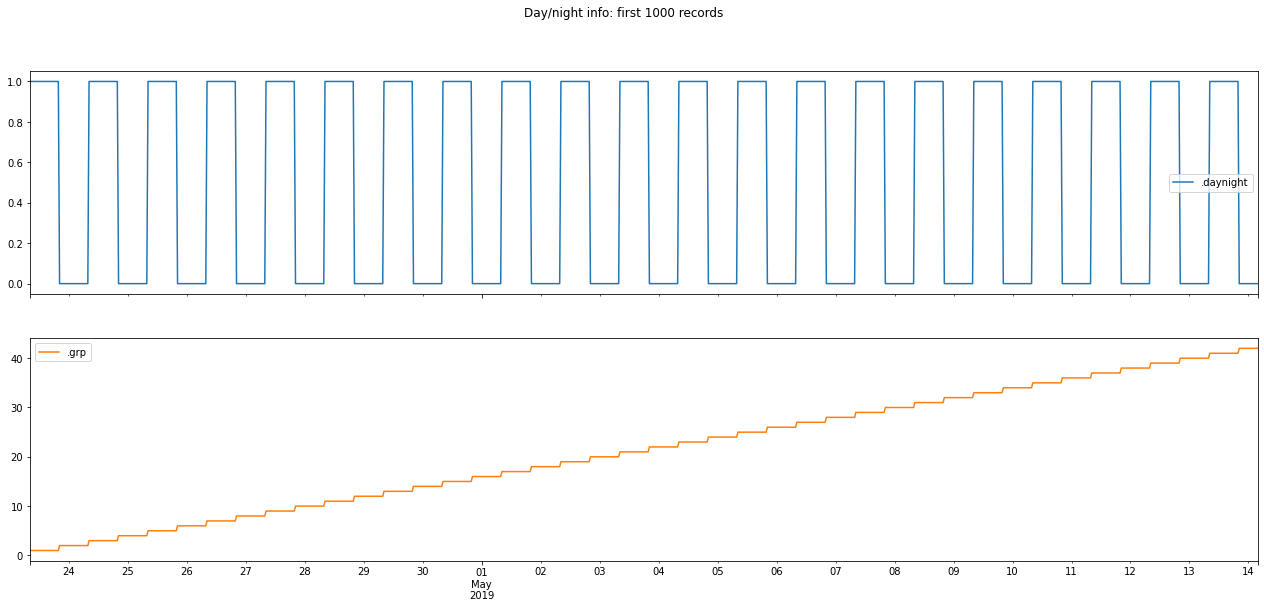

In [31]:
_daynight_grps_df.iloc[0:1000].plot(subplots=True, figsize=(22,9), title="Day/night info: first 1000 records");

#### Add Group Start Times
Add starting datetime, month and week for each group.

In [32]:
# New df to assemble time info, will be merged with main data later
_timeinfo_df = pd.DataFrame(index=df.index)

# Add timestamp index as data column
_timeinfo_df['.TIMESTAMP'] = _timeinfo_df.index
_timeinfo_df['.grp'] = _daynight_grps_df['.grp'].copy()

In [33]:
# Mapping
# For each _daynight_id, add its starting datetime
# Create mapping dict that is used to assign the start datetime to each _daynight_id
_grp_start = _timeinfo_df.groupby('.grp')['.TIMESTAMP'].idxmin()
_map_grp_start = _grp_start.to_dict()

print("First 10 keys and values in mapping dict:")
for x in list(_map_grp_start)[0:10]:
    print(f"key: {x}, value: {_map_grp_start[x]}")

First 10 keys and values in mapping dict:
key: 1, value: 2019-04-23 08:15:00
key: 2, value: 2019-04-23 20:15:00
key: 3, value: 2019-04-24 08:15:00
key: 4, value: 2019-04-24 20:15:00
key: 5, value: 2019-04-25 08:15:00
key: 6, value: 2019-04-25 20:15:00
key: 7, value: 2019-04-26 08:15:00
key: 8, value: 2019-04-26 20:15:00
key: 9, value: 2019-04-27 08:15:00
key: 10, value: 2019-04-27 20:15:00


In [34]:
# Use mapping dict to assign the start datetime to each _grp
_timeinfo_df['.grp_start'] = _timeinfo_df['.grp'].map(_map_grp_start)  

# Add start month and week for groups
_timeinfo_df['.grp_start_month'] = _timeinfo_df['.grp_start'].dt.month
_timeinfo_df['.grp_start_week'] = _timeinfo_df['.grp_start'].dt.isocalendar()['week']

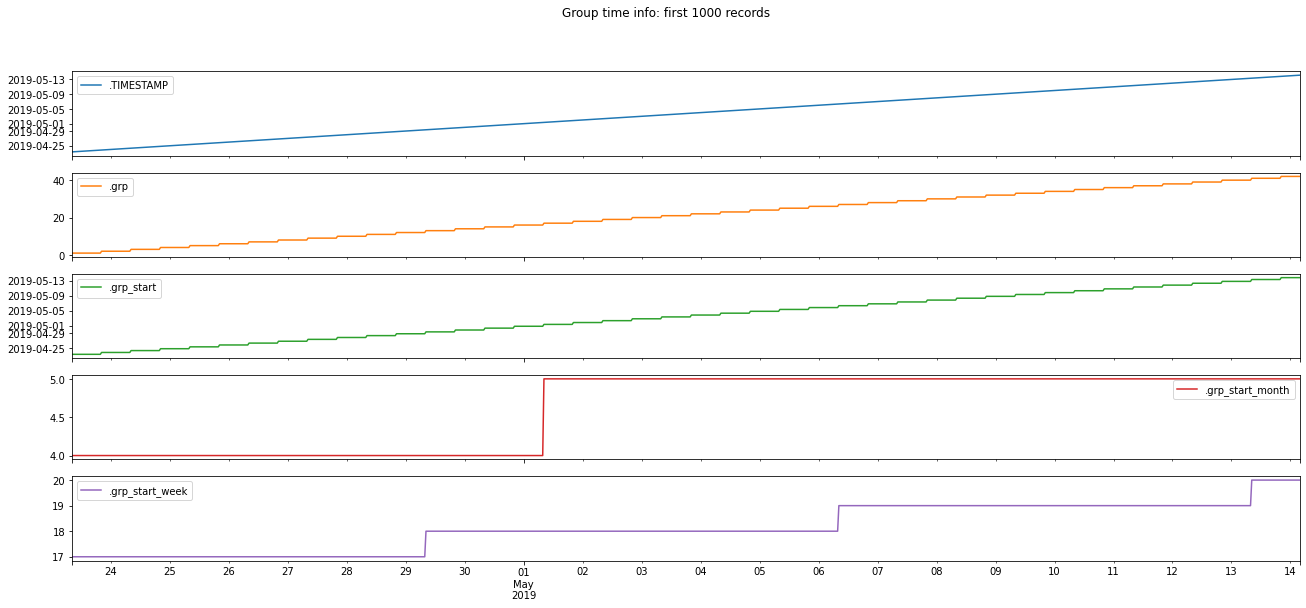

In [35]:
_timeinfo_df.iloc[0:1000].plot(subplots=True, figsize=(22,9), title="Group time info: first 1000 records");

#### Add Time Since
Count time (records) since last occurrence, e.g. time since last precipitation.

In [36]:
_list_timesince_vars = ['PREC', '.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.ploughing+soilprep', '.Norg+Nmin']

# New df to assemble timesince, will be merged with main data later
_timesince_df = pd.DataFrame()

# Function
def timesince(series):
    flag = series.copy()
    flag.loc[series > 0] = 0  # Set flag to zero where series > 0, for correct timesince counting
    flag.loc[series == 0] = 1  # Set flag to one where series = 0
    flag.loc[series.isnull()] = 1  # Set flag to one where series is missing
    # kudos, fantastic: https://stackoverflow.com/questions/27626542/counting-consecutive-positive-value-in-python-array
    timesince = flag * (flag.groupby((flag != flag.shift()).cumsum()).cumcount() + 1)
    return timesince

if use_timesince_vars:
    for v in _list_timesince_vars:
        if v in df.columns:
            print(v)
            _timesince_df[v] = df[v].copy()        

    # Calculate timesince for selected vars
    for v in _timesince_df.columns:
        var_timesince = f'.timesince_{v}'
        _timesince_df[var_timesince] = timesince(series=_timesince_df[v])    

    # Get list of timesince vars
    _timesince_cols = [x for x in _timesince_df.columns if '.timesince_' in x]    
    print(_timesince_cols)

    # Plot
    plt.figure(figsize=(24, 9))
    plt.title("Timesince Variables")
    for col in _timesince_cols:
        label = col.replace('_', '')  # Matplotlib legend cannot show variables starting with an _underscore
        plt.plot_date(_timesince_df.index, _timesince_df[col], label=label)
    plt.legend();

#### Add To Subset
Add created additional variables to subset.

In [37]:
# Add to main data
df = pd.concat([df, _daynight_grps_df, _timeinfo_df, _timesince_df], axis=1)
df = df.loc[:,~df.columns.duplicated()]  # Some columns are now duplicated due to the merging, remove them
df = df.drop(['.TIMESTAMP', '.grp_start', '.grp', '.grp_start_month', '.grp_start_week'], axis=1)  # Remove for now

#### Check

In [38]:
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)
display(df.head(3))
display(df.columns)

,TS_0.05,WFPS_0.05,PREC,target,.daynight
2019-04-23 08:15:00,NaN,NaN,NaN,NaN,1.0
2019-04-23 08:45:00,NaN,NaN,NaN,NaN,1.0
2019-04-23 09:15:00,NaN,NaN,NaN,NaN,1.0


Index(['TS_0.05', 'WFPS_0.05', 'PREC', 'target', '.daynight'], dtype='object')

# Random Forest

## Prepare Data Subset
Make subset of data that is used in RF.

In [39]:
# Make copy to work with
subset_df = df.copy()

In [40]:
# Select year
subset_df = subset_df.loc[subset_df.index.year == SELECT_YEAR]

if SELECT_YEAR == 2020:
    start_date = pd.to_datetime('2020-01-01 00:15:00')
    end_date = pd.to_datetime('2020-09-16 23:45')    
elif SELECT_YEAR == 2019:
    start_date = pd.to_datetime('2019-01-01 00:15:00')
    end_date = pd.to_datetime('2019-10-30 23:45')    

subset_df['temp_datetime_col'] = subset_df.index
subset_df.loc[(subset_df['temp_datetime_col'] > start_date) & (subset_df['temp_datetime_col'] < end_date)]  
subset_df = subset_df[subset_df['temp_datetime_col'].between(start_date, end_date)]
subset_df = subset_df.drop('temp_datetime_col', axis=1)

# Datetime of first and last available measurement of target
_first_target_value_dt = subset_df['target'].dropna().index[0]
_last_target_value_dt = subset_df['target'].dropna().index[-1]
print(f"First measured value of target: {_first_target_value_dt}")
print(f"Last measured value of target: {_last_target_value_dt}")

# Restrict time range to first and last available data point of target
subset_df = subset_df.loc[_first_target_value_dt:_last_target_value_dt]

First measured value of target: 2019-05-10 12:15:00
Last measured value of target: 2019-07-22 19:15:00


In [41]:
# Add second header row, needed for RandomForestTS class
lst_for_empty_units = []
for e in range(len(subset_df.columns)):  ## generate entry for all cols in df
    lst_for_empty_units.append('-')
subset_df.columns = [subset_df.columns, lst_for_empty_units]  ## conv column index to multiindex

In [42]:
# # subset_df.to_csv("test.csv")
# DAY_df = subset_df.copy()
# daynight_col = ('.daynight', '-')
# DAY_df = DAY_df.loc[DAY_df[daynight_col] == 0, :]
# DAY_df
# subset_df = DAY_df.copy()

## Model setup

In [43]:
target_col = ('target', '-')
rfts = RandomForestTS(df=subset_df,
                      target_col=target_col,
                      verbose=1,
                      random_state=42,
                      rfecv_step=1,
                      rfecv_min_features_to_select=20,
                      rf_rfecv_n_estimators=100,
                      rf_n_estimators=1000,
                      bootstrap=True)

## Rolling Variants

In [44]:
if include_rolling_variants:
    
    # No rolling variants for some vars
    _donotroll_ids = ['.timesince', '.MGMT', '.ploughing',  '.soilprep', '.Norg', '.Nmin', '.harvest', '.sowing', '.daynight']
    donotroll_cols = [target_col]
    for col in rfts.df.columns:
        if any(_donotroll_id in col[0] for _donotroll_id in _donotroll_ids):
            donotroll_cols.append(col)
    
    rfts.rolling_variants(records=6,
                          aggtypes=['mean'],
                          exclude_cols=donotroll_cols)    
else:
    print("No rolling variants calculated.")

No rolling variants calculated.


In [45]:
rfts.df.columns

MultiIndex([(  'TS_0.05', '-'),
            ('WFPS_0.05', '-'),
            (     'PREC', '-'),
            (   'target', '-'),
            ('.daynight', '-')],
           )

## Lagged Variants

In [46]:
if include_lagged_variants:       
    
    if include_rolling_variants:
        # Create lagged variants for rolling variants only
        exclude_cols = []
        [exclude_cols.append(col) for col in rfts.df.columns if 'r-' not in col[0]]
        print(f"No lagged variants will be created for the following columns:{exclude_cols}\n")
    
    rfts.steplagged_variants(stepsize=6,
                             stepmax=24,
                             exclude_cols=exclude_cols)
else:
    print("No lagged variants calculated.")

No lagged variants calculated.


In [47]:
list(rfts.df.columns)

[('TS_0.05', '-'),
 ('WFPS_0.05', '-'),
 ('PREC', '-'),
 ('target', '-'),
 ('.daynight', '-')]

## Add Timestamp As Features

In [48]:
if timestamp_as_features:
    rfts.include_timestamp_as_features(doy_as_feature=True,
                                       week_as_feature=True,
                                       month_as_feature=True,
                                       hour_as_feature=True)

## Check

In [49]:
# [print(col) for col in rfts.df.columns]
pd.set_option('display.max_columns', 99)
pd.set_option('display.max_rows', 99)
display(rfts.df)
columns_in_dataset = list(rfts.df.columns)
# [print(col) for col in columns_in_dataset]
columns_in_dataset

,TS_0.05,WFPS_0.05,PREC,target,.daynight
,-,-,-,-,-
2019-05-10 12:15:00,13.700000,71.838461,0.0,-4.69694,1.0
2019-05-10 12:45:00,14.266667,71.635144,0.0,-3.89009,1.0
2019-05-10 13:15:00,14.833333,71.543457,0.0,-4.85069,1.0
2019-05-10 13:45:00,15.533333,71.380086,0.0,NaN,1.0
2019-05-10 14:15:00,15.900000,71.328927,0.0,7.82501,1.0
...,...,...,...,...,...
2019-07-22 17:15:00,30.366667,45.729298,0.0,NaN,1.0
2019-07-22 17:45:00,30.200000,45.630560,0.0,NaN,1.0
2019-07-22 18:15:00,29.866667,45.447036,0.0,11.96880,1.0


[('TS_0.05', '-'),
 ('WFPS_0.05', '-'),
 ('PREC', '-'),
 ('target', '-'),
 ('.daynight', '-')]

## Feature Reduction
Identify most important features for predicting target.

In [50]:
rfts.feature_reduction()
reduced_df, feat_reduction_results = rfts.get_reduced_dataset()



[FEATURE REDUCTION]    START ==============================
[FEATURE REDUCTION]    Parameters:  {'cv': TimeSeriesSplit(max_train_size=None, n_splits=5), 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': -1, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(n_jobs=-1, random_state=42), 'min_features_to_select': 20, 'n_jobs': -1, 'scoring': 'explained_variance', 'step': 1, 'verbose': 1}
[FEATURE REDUCTION]    Number of features *before* reduction:  4
[FEATURE REDUCTION]    

In [51]:
feat_reduction_results['feature_importances_after'].loc[feat_reduction_results['feature_importances_after']['importance'] > 0.01]

,feature,importance
1,"(WFPS_0.05, -)",0.465952
0,"(TS_0.05, -)",0.464898
2,"(PREC, -)",0.038303
3,"(.daynight, -)",0.030848


## Build Final Model

In [52]:
rfts.build_final_model()



[FINAL MODEL]    START ==============================
[FINAL MODEL]    Target column:  ('target', '-')  (498 values)
[FINAL MODEL]    Number of features used in model:  4
[FINAL MODEL]    Names of features used in model:  [('WFPS_0.05', '-'), ('TS_0.05', '-'), ('PREC', '-'), ('.daynight', '-')]
[FINAL MODEL]    Model parameters:  {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 1000, 'n_jobs': -1, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
[FINAL MODEL]    Model MAE:  2.0803000208192794
[FINAL MODEL]    Model MAPE:  -4.356%
[FINAL MODEL]    Model R2:  0.8380859341799001
[FINAL MODEL]    Model features:
              Var  Importance
0  (WFPS_0.05, -)        0.47
1    (TS_0.05, -)        0.46
2       (PREC, 

## Fill gaps
Fill gaps in target variable, using the model with reduced features.

In [53]:
rfts.gapfilling()
gapfilled_df, gf_results = rfts.get_gapfilled_dataset()



[GAPFILLING]    START ==============================
Added timestamp as columns: [('.DOY', '[day_of_year]'), ('.WEEK', '[week_of_year]'), ('.MONTH', '[month]'), ('.HOUR', '[hour]')]
[GAPFILLING]    feature_names:  [('WFPS_0.05', '-'), ('TS_0.05', '-'), ('PREC', '-'), ('.daynight', '-')]
[GAPFILLING]    num_features:  4
[GAPFILLING]    first_timestamp:  2019-05-10 12:15:00
[GAPFILLING]    last_timestamp:  2019-07-22 19:15:00
[GAPFILLING]    max_potential_vals:  3519
[GAPFILLING]    target_numvals:  525
[GAPFILLING]    target_numgaps:  2994
[GAPFILLING]    target_gapfilled_numvals:  3519
[GAPFILLING]    target_gapfilled_numgaps:  0
[GAPFILLING]    target_gapfilled_flag_notfilled:  525
[GAPFILLING]    target_gapfilled_flag_with_hq:  2855
[GAPFILLING]    target_gapfilled_flag_with_fallback:  139
[GAPFILLING]    predictions_hq_numvals:  3353
[GAPFILLING]    predictions_hq_numgaps:  166
[GAPFILLING]    predictions_fallback_numvals:  3519
[GAPFILLING]    predictions_fallback_numgaps:  0
[GA

In [54]:
gapfilled_df

,target,.predictions,.gap_predictions,QCF_target#gfRF,target#gfRF,.predictions_fallback,.gapfilled_cumulative
,-,[aux],[aux],[0=measured],-,[aux],[aux]
2019-05-10 12:15:00,-4.69694,-3.860747,NaN,0,-4.696940,-3.308152,-4.696940
2019-05-10 12:45:00,-3.89009,-3.634238,NaN,0,-3.890090,-3.308152,-8.587030
2019-05-10 13:15:00,-4.85069,-2.191076,NaN,0,-4.850690,0.416327,-13.437720
2019-05-10 13:45:00,NaN,5.592745,5.592745,1,5.592745,0.416327,-7.844975
2019-05-10 14:15:00,7.82501,5.372886,NaN,0,7.825010,6.406790,-0.019965
...,...,...,...,...,...,...,...
2019-07-22 17:15:00,NaN,-0.833210,-0.833210,1,-0.833210,0.467591,7644.963181
2019-07-22 17:45:00,NaN,0.556016,0.556016,1,0.556016,0.467591,7645.519198
2019-07-22 18:15:00,11.96880,7.713251,NaN,0,11.968800,9.734146,7657.487998


## Save To File

In [55]:
gapfilled_df.to_csv(OUTFILE)

## Summary

In [56]:
gf_results

{'feature_names': [('WFPS_0.05', '-'),
  ('TS_0.05', '-'),
  ('PREC', '-'),
  ('.daynight', '-')],
 'num_features': 4,
 'first_timestamp': Timestamp('2019-05-10 12:15:00'),
 'last_timestamp': Timestamp('2019-07-22 19:15:00'),
 'max_potential_vals': 3519,
 'target_numvals': 525,
 'target_numgaps': 2994,
 'target_gapfilled_numvals': 3519,
 'target_gapfilled_numgaps': 0,
 'target_gapfilled_flag_notfilled': 525,
 'target_gapfilled_flag_with_hq': 2855,
 'target_gapfilled_flag_with_fallback': 139,
 'predictions_hq_numvals': 3353,
 'predictions_hq_numgaps': 166,
 'predictions_fallback_numvals': 3519,
 'predictions_fallback_numgaps': 0}

In [57]:
# Flag info
_flag = gapfilled_df[('QCF_target#gfRF', '[0=measured]')]
_unique_values = pd.unique(_flag.values.ravel())
_counts_series = pd.Series(index=_unique_values, dtype=int)
_counts_series = _flag.value_counts(dropna=False)
_counts_series

1    2855
0     525
2     139
Name: (QCF_target#gfRF, [0=measured]), dtype: int64

In [58]:
list(gapfilled_df.columns)

[('target', '-'),
 ('.predictions', '[aux]'),
 ('.gap_predictions', '[aux]'),
 ('QCF_target#gfRF', '[0=measured]'),
 ('target#gfRF', '-'),
 ('.predictions_fallback', '[aux]'),
 ('.gapfilled_cumulative', '[aux]')]

### Plot: Overview

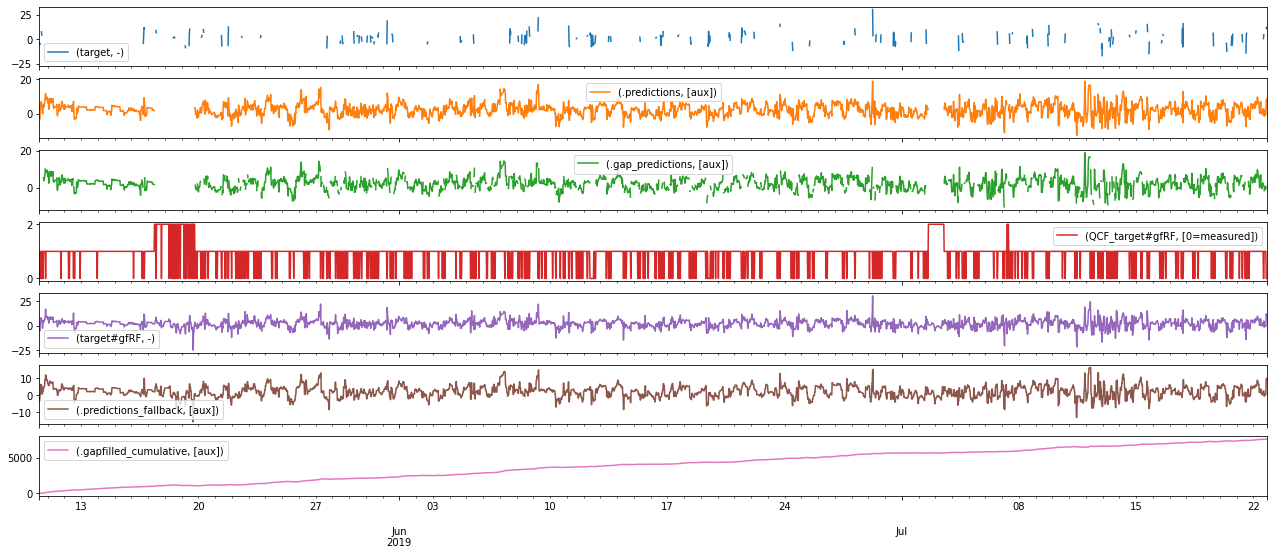

In [59]:
gapfilled_df.plot(subplots=True, figsize=(22, 9));

### Plot: Predictions vs. Target

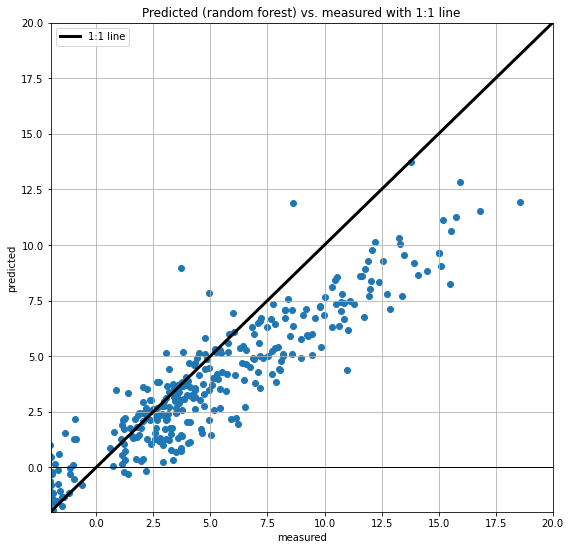

In [60]:
# Plot all targets vs. predictions
x_col = ('target', '-')
y_col = ('.predictions', '[aux]')
plt.figure(figsize=(9, 9))
plt.scatter(gapfilled_df[x_col], gapfilled_df[y_col])
plt.title("Predicted (random forest) vs. measured with 1:1 line")
plt.axhline(0, color='black', lw=1)
plt.plot([-2,20],[-2,20], 'black', linewidth=3, label="1:1 line", ls="-")
plt.xlabel("measured")
plt.ylabel("predicted")
plt.xlim(-2, 20)
plt.ylim(-2, 20)
plt.grid()
plt.legend();

### Plot: Measured And Gap-filled Values

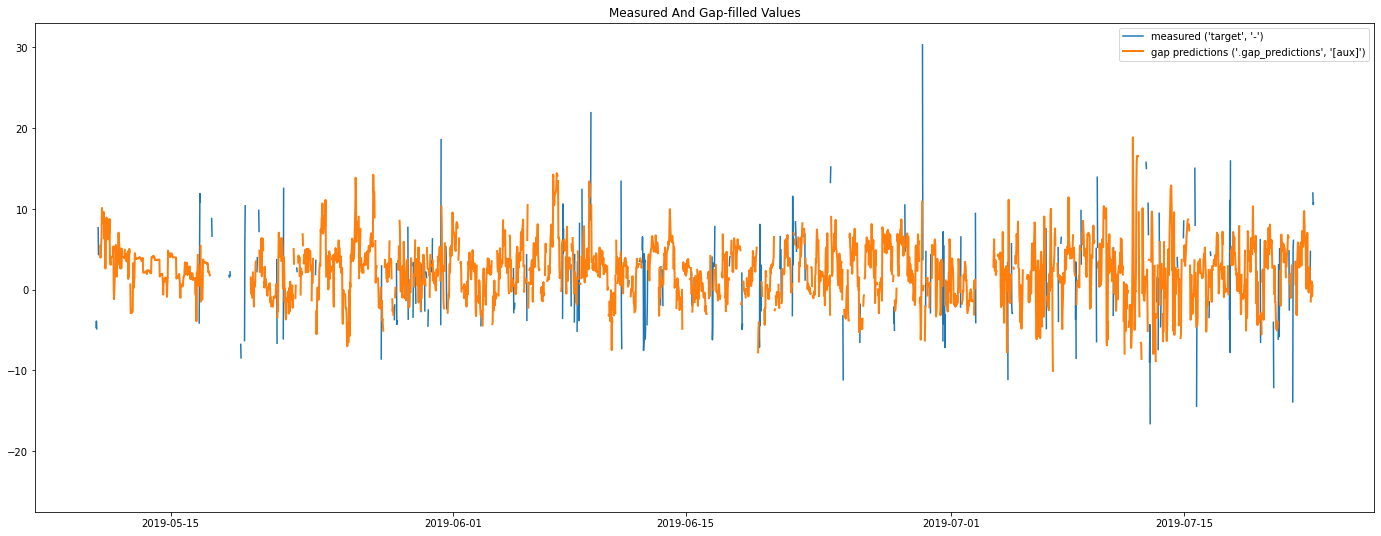

In [61]:
# Plot all targets and predictions
x_col = ('target', '-')
y_col = ('.gap_predictions', '[aux]')
plt.figure(figsize=(24, 9))
plt.title("Measured And Gap-filled Values")
plt.plot(gapfilled_df[x_col], label=f"measured {x_col}")
plt.plot(gapfilled_df[y_col], label=f"gap predictions {y_col}", lw=2)
plt.legend()
plt.show()

### Plot: Gap-filled Time Series

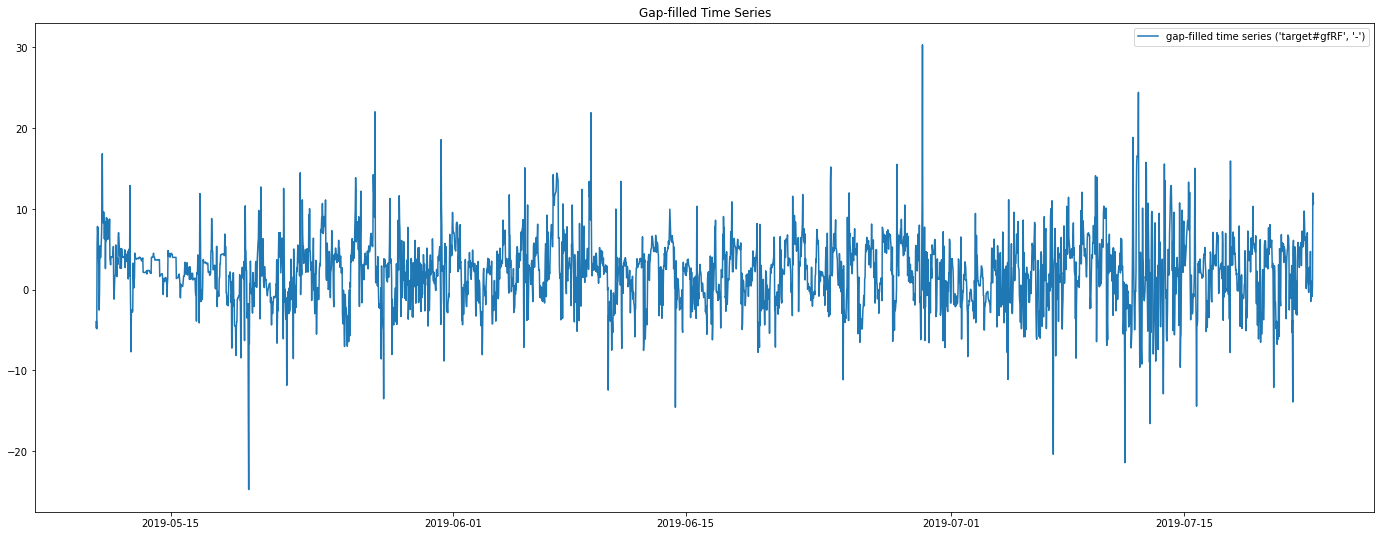

In [62]:
col = ('target#gfRF', '-')
plt.figure(figsize=(24, 9))
plt.title("Gap-filled Time Series")
plt.plot(gapfilled_df[col], label=f"gap-filled time series {col}")
plt.legend()
plt.show()

### Plot: Gap-filled Time Series (Daily Average)

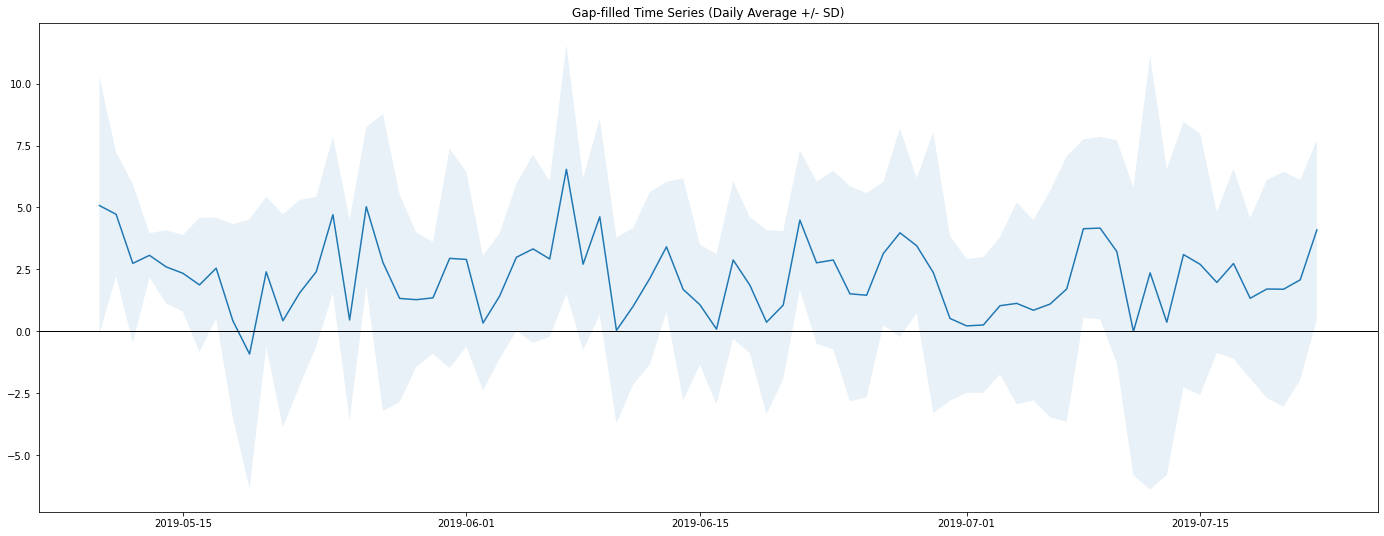

In [63]:
col = ('target#gfRF', '-')
plt.figure(figsize=(24, 9))
plt.title("Gap-filled Time Series (Daily Average +/- SD)")



# Aggregate by day
mean_df_agg = gapfilled_df.groupby(gapfilled_df.index.date).aggregate({col: ['mean', 'std']})

# Average +/- standard deviation
mean_df_agg['mean_plus_sd_col'] = mean_df_agg[col]['mean'] + mean_df_agg[col]['std']
mean_df_agg['mean_minus_sd_col'] = mean_df_agg[col]['mean'] - mean_df_agg[col]['std']

plt.plot(mean_df_agg.index,
        mean_df_agg[col]['mean'])

plt.fill_between(mean_df_agg.index,
                mean_df_agg['mean_plus_sd_col'],
                mean_df_agg['mean_minus_sd_col'],
                alpha=0.1)


# plt.legend()
plt.axhline(0, lw=1, color='black')
plt.show()
# mean_df_agg

### Visualize tree

In [64]:
# # Visualize one of the decision trees
# from sklearn.tree import export_graphviz
# import pydot
# tree = rfts.model.estimators_[2]  # # Pull out one tree from the forest
# export_graphviz(tree, out_file = 'tree.dot', feature_names=rfts.feature_names, rounded = True, precision = 1)  # Export the image to a dot file
# (graph, ) = pydot.graph_from_dot_file('tree.dot')  # Use dot file to create a graph
# graph.write_png('tree.png')  # Write graph to a png file

In [65]:
# rfts.feat_reduction_results